<a href="https://colab.research.google.com/github/g-vaughan/classic_machine_learning/blob/main/predicting_heart_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
[Data Source](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

Cardiovascular diseases are the leading cause of death worldwide, claiming an estimated 17.9 million lives annually, which represents 31% of all global deaths. Early detection and diagnosis are crucial in reducing the impact of heart disease, and machine learning techniques can play a significant role in predicting the likelihood of an individual having heart disease. In this notebook, I will compare various classical machine learning methods to predict a binary output: whether or not a person has heart disease. Developing such a model can assist healthcare professionals in making more accurate and timely diagnoses, leading to better preventive care, personalized treatment plans, and improved patient outcomes.


### **Data Exploration / Feature Engineering**
* The dataset has a fairly balanced distribution of classes.
* Duplicate entries have been removed, and there are no missing values.
* Categorical (non-numeric) features are encoded as follows:
    * **Label Encoding** is applied to binary categorical variables: `Sex_binary` and `ExerciseAngina_binary`.
    * **Ordinal Encoding** is used for variables with an inherent order: `ST_Slope_encoded`.
    * **One-Hot Encoding** is applied to remaining nominal categorical features with low cardinality: `ChestPainType` and `RestingECG`.

* Visualisations have been created to explore the relationship between each feature and the target variable (HeartDisease) to help identify which features might be strong predictors for the classification task. Features expected to have high importance include:
    *   ExerciseAngina
    *   ChestPainATA
    *   ST_Slope
    *   Sex
    *   FastingBS
    *   Age
    *   Max Heart Rate
    *   Oldpeak

### **Models**

The dataset is first split into a training/testing set (80%) and a validation set (20%).  
Within the training/testing set, **k-fold cross-validation** is used to train and evaluate each model.

The following models are explored. **Hyperparameters** are tuned using GridSearchCV for the simple models (KNN, NaiveBayes, Decision Tree) and RandomSearchCV for the more complex models (Random Forest, XGBoost).
* **Logistic Regression**
    - With regularisation
* **K-Nearest Neighbors**
    - In the KNN evaluation, I plot all the results from the GridSearch and use the input() function to prompt the user to manually select a value for K. This ensures that the final choice considers both performance and simplicity, helping avoid the selection of a high K value that offers only marginal accuracy improvements at the cost of increased model complexity.
* **Naive Bayes**
    - For the Naive Bayes experiment, I use Multinomial Naive Bayes since all but one of the features are categorical. To handle the continuous feature, I apply binning to convert it into a categorical form. While this preserves the shape of the original distribution, it violates one of the core assumptions of the Multinomial model — that features represent discrete counts. This mismatch may explain the model’s relatively poor performance compared to others.
* **Support Vector Machine (SVM)**
    - With regularisation
* **Decision Tree**
    - In the decision tree experiment, the resulting tree is relatively small, allowing me to plot each split and leaf to enhance interpretability.
* **Random Forest**
* **XGBoost**

### **Evaluation Metrics**
**accuracy_mean**: The average accuracy score achieved by the model across all cross-validation folds for the best found hyperparameters. This gives a reliable estimate of how well the model performs on unseen data. Accuracy is a suitable metric here because the dataset has balanced classes, so it fairly reflects the model’s overall performance without bias toward any class.

**accuracy_variance**: The variance (square of the standard deviation) of the accuracy scores across the cross-validation folds for the best hyperparameters. This measures how consistent the model’s performance is; a lower variance indicates more stable results.

### **Model Selection**
*   As expected, the ensemble models achieve the highest accuracy.
*   XGBoost stands out with the highest mean accuracy of 0.872 and a very low variance (0.000296), showing consistent performance across different data splits, making it the preferred model for this task.
*   If interpretability is a priority (e.g., explaining predictions to clinicians), logistic regression is a strong alternative since its accuracy is only slightly lower than the top models.
*   As a compromise, I chose the XGBoost model and use SHAP values to improve explainability.


### **Conclusion**
When evaluated on the hold out set, the model correctly classified 72 patients without heart disease and 94 patients with heart disease. It misclassified 8 patients without heart disease as having the disease (false positives) and 10 patients with heart disease as healthy (false negatives). Overall, the model shows good performance with relatively balanced errors, slightly favoring correct detection of heart disease cases.

In cross-validation, the model achieved an average accuracy of 87%, while in this final evaluation, accuracy improved to **90%**. This increase suggests the model generalizes well to unseen data and that the final test set may have been slightly easier to classify. However, the close accuracy values indicate the model is stable and reliable, reducing concerns about overfitting.

We used **SHAP graphs** to interpret the model, which highlighted similar features to those identified during the initial exploratory data analysis, confirming the relevance of our feature selection.

For future work, focusing on reducing false negatives further would be important to minimize missed heart disease diagnoses.


# Imports

In [1]:
# Set up
import pandas as pd
import kagglehub
import os
import numpy as np
import math

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import graphviz

# Preprocessing & evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from statistics import mean
from sklearn.metrics import accuracy_score, confusion_matrix
import shap

# Modelling
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.base import clone

In [2]:
# Option 1: If the dataset is not already donwloaded, uncomment this cell to log in and download the dataset
kagglehub.login()

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
print(path)
os.listdir(path)

/kaggle/input/heart-failure-prediction


['heart.csv']

In [3]:
# Option 2: If the dataset is already downloaded, ammend this path to be accurate for you
path = '/kaggle/input/heart-failure-prediction'

In [4]:
file_path = path + '/' + os.listdir(path)[0]
df = pd.read_csv(file_path)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Data Exploration

Data Features:
  * **Age**: age of the patient (years)
  * **Sex**: sex of the patient (M: Male, F: Female)
  * **ChestPainType**: chest pain type
      *   TA: Typical Angina
      *   ATA: Atypical Angina
      *   NAP: Non-Anginal Pain
      *   ASY: Asymptomatic
  * **RestingBP**: resting blood pressure (mm Hg)
  * **Cholesterol**: serum cholesterol (mm/dl)
  * **FastingBS**: fasting blood sugar
      *   1: if FastingBS > 120 mg/dl
      *   0: otherwise
  * **RestingECG**: resting electrocardiogram results
      *   Normal: Normal,
      *   ST: having ST-T wave abnormality
      *   LVH: showing probable or definite left ventricular hypertrophy
  * **MaxHR**: maximum heart rate achieved
  * **ExerciseAngina**: exercise-induced angina
      *   Y: Yes
      *   N: No
  * **Oldpeak**: oldpeak = ST (Numeric value measured in depression)
  * **ST_Slope**: the slope of the peak exercise ST segment
      *   Up: upsloping
      *   Flat: flat
      *   Down: downsloping
  * **HeartDisease**: output class
      *   1: heart disease
      *   0: Normal

In [5]:
target = "HeartDisease"

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe().round(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [8]:
df['HeartDisease'].value_counts()

,count
HeartDisease,
1,508
0,410


In [9]:
print(df.isnull().sum())

#msno.matrix(df)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [10]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

918
918


## Non-numeric features

In [11]:
non_numeric_features = df.select_dtypes(exclude='number').columns
print(non_numeric_features, '\n')
non_numeric_df = df[non_numeric_features]
non_numeric_df

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object') 



,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


In [12]:
#Get number of unique values in each column
non_numeric_df.nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


### Encoding non-numeric features

### Label encoding
Label encoding is used for binary categories.

In [13]:
#LabelEncoder assigns integers in arbitrary order based on lexicographical sorting
le = LabelEncoder()
df['Sex_binary'] = le.fit_transform(df['Sex'])
df['ExerciseAngina_binary'] = le.fit_transform(df['ExerciseAngina'])
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0


### Ordinal Encoding
Ordinal Encoding is used for categorical variables with meaningful order.

In [14]:
# ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
encoder = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']])
df['ST_Slope_encoded'] = encoder.fit_transform(df[['ST_Slope']]).astype(int)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0,2
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0,2
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0,1


### One Hot Encoding
One Hot Encoding is used for categories that are not binary, do not have meaningful order.

If these were highly dimensional we would use PCA as a secondary step to limit the number of features.

In [15]:
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(df[['ChestPainType', 'RestingECG']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['ChestPainType', 'RestingECG']))
encoded_df = encoded_df.drop(columns=['RestingECG_Normal', 'ChestPainType_ASY']) # Removing baseline variables (no chest pain and normal ECG) to prevent collinearity problems
encoded_df = encoded_df.astype(int)
encoded_df

,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,1
3,0,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
913,0,0,1,0,0
914,0,0,0,0,0
915,0,0,0,0,0
916,1,0,0,1,0


In [16]:
df = df.merge(encoded_df, left_index=True, right_index=True)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0,2,1,0,0,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0,1,0,1,0,0,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0,2,1,0,0,0,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1,1,0,0,0,0,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0,1,0,0,1,0,0
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0,1,0,0,0,0,0
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1,1,0,0,0,0,0
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0,1,1,0,0,1,0


In [17]:
# Remove unencoded categorical variables
df = df.drop(columns = non_numeric_features)

# Print non-numeric columns to ensure all columns are numeric
print('Non numeric columns:', df.select_dtypes(exclude='number').columns)

Non numeric columns: Index([], dtype='object')


In [18]:
df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,40,140,289,0,172,0.0,0,1,0,2,1,0,0,0,0
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,0
2,37,130,283,0,98,0.0,0,1,0,2,1,0,0,0,1
3,48,138,214,0,108,1.5,1,0,1,1,0,0,0,0,0
4,54,150,195,0,122,0.0,0,1,0,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,1,0,0,1,0,0
914,68,144,193,1,141,3.4,1,1,0,1,0,0,0,0,0
915,57,130,131,0,115,1.2,1,1,1,1,0,0,0,0,0
916,57,130,236,0,174,0.0,1,0,0,1,1,0,0,1,0


# Visualisations

In [19]:
sns.set_style("whitegrid")
palette = {0: 'royalblue', 1: 'crimson'}

## Categorical Features

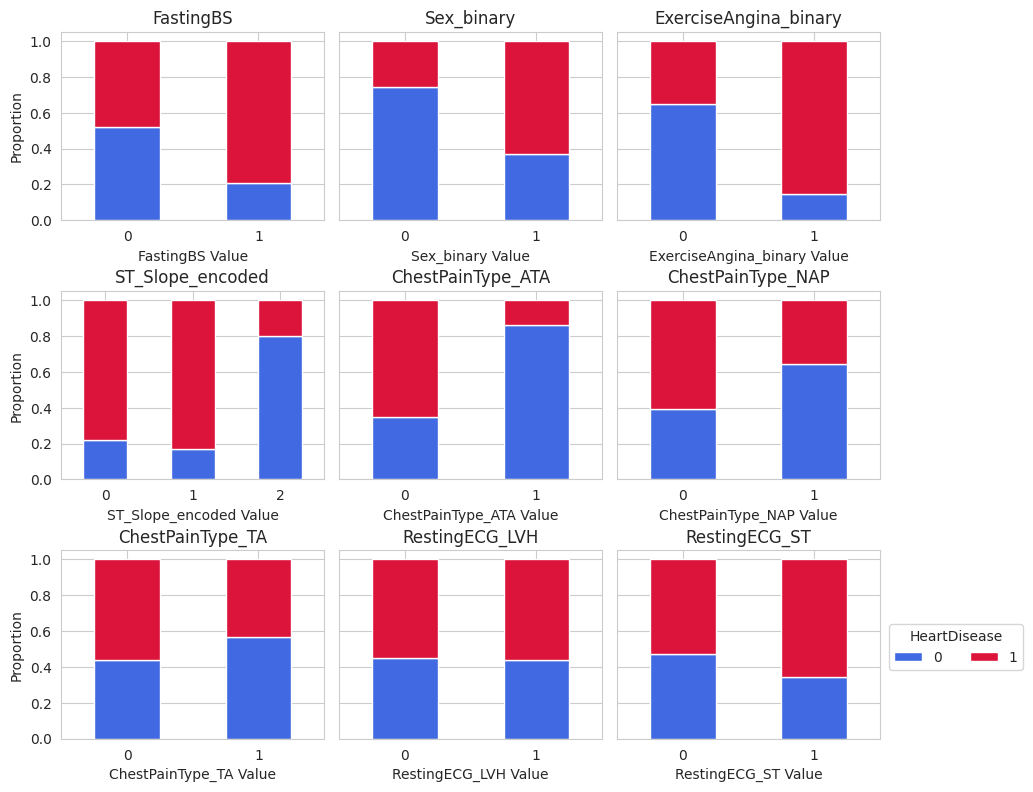

In [20]:
# Select Features
target = 'HeartDisease'
binary_features = [col for col in df.columns if col != target and df[col].nunique() <=3]

# Create Axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), sharey=True)
axes = axes.flatten()

# Plot stacked bar charts
for ax, feature in zip(axes, binary_features):
    cross_tab = pd.crosstab(df[feature], df[target], normalize='index')
    colors = [palette[col] for col in cross_tab.columns]
    cross_tab.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f'{feature}')
    ax.set_xlabel(f'{feature} Value')
    ax.set_ylabel('Proportion')
    ax.legend_.remove()  # Remove legends from all but one to reduce clutter
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title=target, bbox_to_anchor=(1.15, 0.2), ncol=len(labels))

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top to fit legend
plt.show()

*   ExerciseAngina, ChestPainATA, and ST_Slope show clear differences in disease proportions across categories and are likely strong predictors. Sex and FastingBS also show noticeable differences and are relevant features, though with slightly less pronounced effects.

*   Other ChestPainType subcategories and RestingECG features provide useful but more nuanced signals; some categories appear to increase risk while others less so, but their predictive power is less distinct.



## Continuous Features

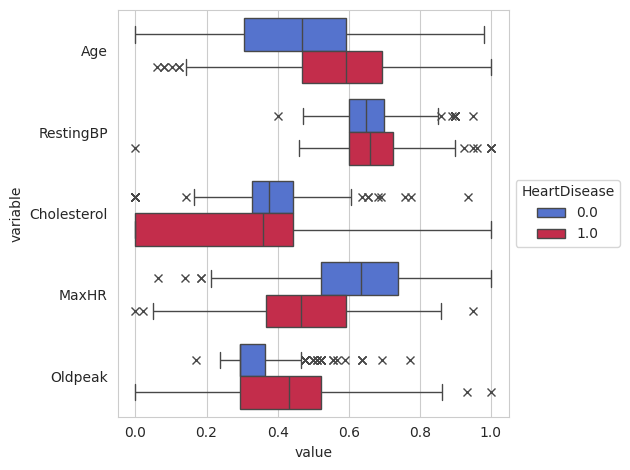

In [21]:
# Select Features
continuous_features = [col for col in df.columns if col != 'HeartDisease' and df[col].nunique() > 3] + ['HeartDisease']

# Format DataFrame
df_boxplot = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)[continuous_features]
df_long = df_boxplot.melt(id_vars=['HeartDisease'])

# Plot and format boxplot
ax = sns.boxplot(data=df_long, x="value", y="variable", orient="h", palette=palette, hue="HeartDisease", flierprops={"marker": "x"},)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='HeartDisease')
plt.tight_layout()
plt.show()

*   **Age**, **MaxHR**, and **Oldpeak** show clear differences between classes and are likely important predictors.
*   **RestingBP** and **Cholesterol** distributions overlap considerably, so their predictive power might be weaker here.
*   Presence of many outliers especially in Cholesterol and Oldpeak suggests some extreme values that may be worth further inspection.








# Models

In [22]:
features_df = df.drop(columns=[target])
y=df[target].values

In [23]:
# Create validation set
x_train_test, x_validate, y_train_test, y_validate = train_test_split(features_df, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
print('Features for training', x_train_test.shape)
print('Features for validation', x_validate.shape)
print('Target for training', y_train_test.shape)
print('Target for validation', y_validate.shape)

Features for training (734, 14)
Features for validation (184, 14)
Target for training (734,)
Target for validation (184,)


In [25]:
results = {}

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Non Tree Based Models

### Logistic Regression
Logistic regression is a calculation used to predict a binary outcome.

Like linear regression, it first computes a weighted sum of the inputs. It then passes the result through the sigmoid function to limit the output to a probability between 0 and 1. If the output is greater than 0.5, the model predicts 1, else it predicts 0.

✔️ Pros:
*   Simple and fast.
*   Output is probabilistic, not just a label.
*   Easy to regularize (to prevent overfitting).
*   Provides an interpretable model (coefficients show feature importance).

❌ Cons:
*   Doesn’t capture complex patterns (e.g., interactions, non-linearity) due to the linear weighted sum of the inputs at the first stage of calculation.
*   Can be sensitive to outliers or irrelevant features.

⚙️ Key Parameters in sklearn.linear_model.LogisticRegression
*   `penalty`: Regularization type ('l2' by default).
*   `C`: Inverse of regularization strength (smaller = stronger regularization).
*   `solver`: Algorithm to use ('lbfgs', 'liblinear', etc.).
    *   For LogisticRegression in scikit-learn, the allowed penalties depend on the solver you choose, so if you don’t specify a solver explicitly, it defaults to 'lbfgs'. 'lbfgs' supports only 'l2' penalty (and 'none' for no regularization). If you try to set penalty='l1' without changing the solver, you'll get an error because 'lbfgs' doesn’t support 'l1'. To use 'l1' penalty, you need to choose a solver like 'liblinear' or 'saga'. If you do grid search over penalties like 'l1' and 'l2', you also need to grid search over compatible solvers at the same time.
*   `max_iter`: Max number of iterations to converge.


##### **GridSearchCV**
GridSearchCV is a brute-force search method that tries every combination of
hyperparameters you give it, trains a model for each, and selects the best
one based on cross-validation performance.

Parameters:
*   `cv`: Cross-validation splitting strategy
*   `scoring`: Evaluation Metric
*   `verbose (int)` Controls the verbosity: the higher, the more messages.
    *   1 : the computation time for each fold and parameter candidate is displayed;
    *   2 : the score is also displayed;
    *   3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.



Accessing results:
*   `.best_estimator_.` Stores the best model
*   `.best_params_.` Stores its parameters
*   `.cv_results_.` contains detailed results for all combinations

In [26]:
# When using GridSearchCV with cross-validation, scaling should be done inside a
# pipeline to ensure it’s applied to each fold and to prevent data leakage
pipeline = Pipeline([
    ('scaler', _),  # Placeholder for scaler, replaced by param_grid
    ('logreg', LogisticRegression(max_iter=1000))  # increase max_iter to ensure convergence
])

# Define the parameter grid
param_grid = [
    # For elasticnet: only saga solver, l1_ratio required
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__C': [0.1, 1, 10],
        'logreg__l1_ratio': [0.1, 0.5, 0.9],
    },
    # For no penalty: solvers lbfgs, newton-cg, sag, saga; C and l1_ratio ignored
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'logreg__penalty': [None],
        'logreg__solver': ['lbfgs', 'saga'],
        'logreg__C': [1],  # C is ignored but needed for GridSearch format
        'logreg__l1_ratio': [None],
    }]

# Initialize GridSearchCV with cross-validation and accuracy scoring
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy'
)

# Fit the model
grid_search.fit(x_train_test, y_train_test)

# Get best index
idx = grid_search.best_index_

# Store the results
results['logistic_regression'] = {
    'accuracy_mean': grid_search.best_score_,
    'accuracy_variance': grid_search.cv_results_['std_test_score'][idx]**2,
    'model': grid_search.best_estimator_.named_steps['logreg'],
    'params': grid_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."


### K-Nearest Neighbors (KNN)
KNN calculates the distance between the test point and all other points in the training set, and then picks the K closest points. The most common label among those neighbours is assigned as the prediction.

✔️ Pros:
*   Simple and easy to understand.
*   No training phase — just stores the data, making it fast for small datasets.
*   Can capture complex decision boundaries (non-linear relationships).
*   Works well for multi-class classification.
*   Very flexible — the number of neighbors, distance metric, and other parameters can be easily adjusted.

❌ Cons:
*   Computationally expensive at prediction time, especially with large datasets (since it needs to compute distances to every point)
*   Sensitive to irrelevant or redundant features, and scales poorly with high-dimensional data (curse of dimensionality).
*   Needs careful choice of K: too small (overfitting), too large (underfitting).
*   Doesn’t perform well with imbalanced data (minority class might be ignored).

⚙️ Key Parameters in sklearn.neighbors.KNeighborsClassifier:
*   `n_neighbors`: Number of neighbors to use for prediction.
*   `weights`: How to weight neighbors (uniform or distance-based).
*   `algorithm`: Algorithm used to compute the nearest neighbors (Default is 'auto',  the algorithm automatically chooses the best method based on the data provided.).
*   `metric`: Distance metric to use (e.g., 'euclidean', 'manhattan')

#### Running GridSearch

In [27]:
%%time

pipeline = Pipeline([
    ('scaler', _), # scaler placeholder to be replaced by functions in the param grid
    ('knn', KNeighborsClassifier())
])


param_grid = {
    'scaler' : [StandardScaler(), MinMaxScaler()],
    'knn__n_neighbors': [i for i in range(1, 30, 1)],
    'knn__weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with KNN, parameter grid, and KFold cross-validation
grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid,
                           cv=kf,
                           scoring='accuracy')

# Fit the model (this will evaluate each K value)
grid_search.fit(x_train_test, y_train_test)

# Get the mean test scores for each K value for plotting
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best K value and its accuracy
print(f"Best Params: {grid_search.best_params_}")

Best Params: {'knn__n_neighbors': 29, 'knn__weights': 'uniform', 'scaler': StandardScaler()}
CPU times: user 14.4 s, sys: 71.5 ms, total: 14.4 s
Wall time: 21.1 s


#### Manually Selecting Parameters from plots

##### Plotting all hyperparmeters

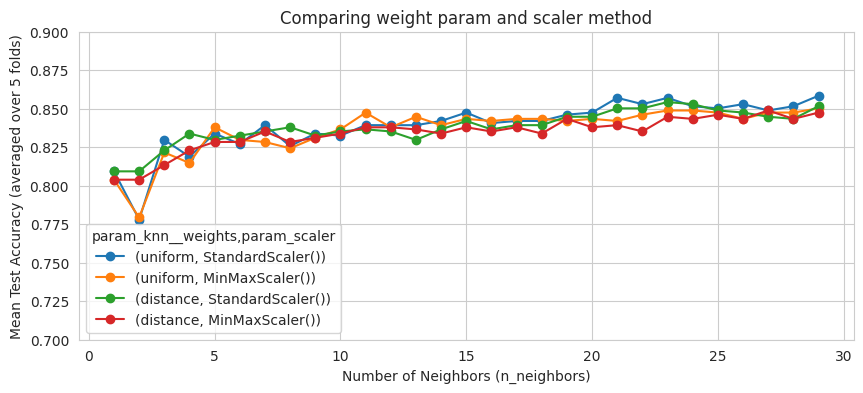

In [28]:
# Extract fold-wise accuracies and weights
results_df = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
results_means_df = results_df[param_cols + ['mean_test_score']]

pivot_df = results_means_df.pivot(index='param_knn__n_neighbors', columns=['param_knn__weights', 'param_scaler'], values='mean_test_score')

# Plot using df.plot()
ax = pivot_df.plot(marker='o', figsize=(10, 4), title='Comparing weight param and scaler method')

# Customize plot
ax.set_xlabel('Number of Neighbors (n_neighbors)')
ax.set_ylabel('Mean Test Accuracy (averaged over 5 folds)')
ax.set_ylim(0.7, 0.9)
ax.grid(True)
plt.show()

##### User input for distance and scalar

In [29]:
distance_input_map = {'d':'distance', 'u':'unform'}
scaler_input_map = {'s':StandardScaler, 'm':MinMaxScaler}

D = input('What value of dsitance would you like to use? \nEnter U for unifrom or D for distance: ')
d = distance_input_map[D.lower()]

S = input('What scaler would you like to use? \nEnter S for Standardscaler or M for MinMaxscaler: ')
s = scaler_input_map[S.lower()]

What value of dsitance would you like to use? 
Enter U for unifrom or D for distance: d
What scaler would you like to use? 
Enter S for Standardscaler or M for MinMaxscaler: s


#### Plot results for given distance and scalar

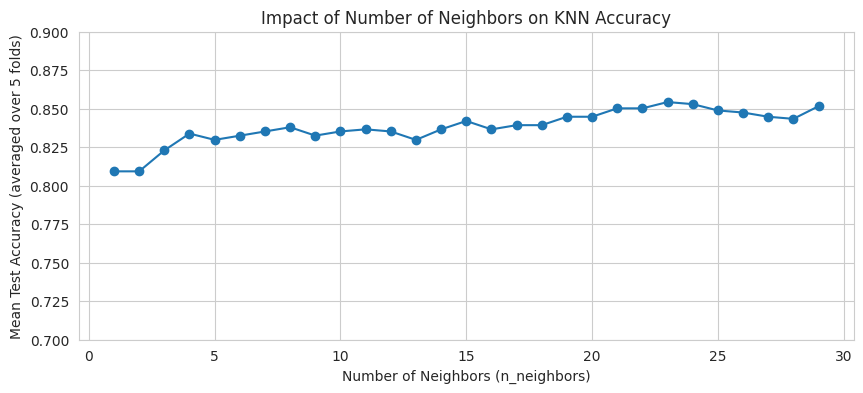

In [30]:
chosen_combo = results_means_df[
    results_means_df['param_scaler'].apply(lambda x: isinstance(x, s)) &
    (results_means_df['param_knn__weights'] == d)
    ]

chosen_combo_pivot = chosen_combo.pivot(index='param_knn__n_neighbors', columns=['param_knn__weights', 'param_scaler'], values='mean_test_score')

# Plot using df.plot()
ax = chosen_combo_pivot.plot(marker='o', figsize=(10, 4), legend=False,
                           title='Impact of Number of Neighbors on KNN Accuracy')

# Customize plot
ax.set_xlabel('Number of Neighbors (n_neighbors)')
ax.set_ylabel('Mean Test Accuracy (averaged over 5 folds)')
ax.set_ylim(0.7, 0.9)
ax.grid(True)
plt.show()

#### User input to select K

In [31]:
K = input('What value of K would you like to use? ')
K = int(K)

What value of K would you like to use? 23


#### Saving results

In [32]:
# Get Results
chosen_combo_results = results_df[
    results_df['param_scaler'].apply(lambda x: isinstance(x, s)) &
    (results_df['param_knn__weights'] == d) &
    (results_df['param_knn__n_neighbors'] == K)
    ]
resulting_accuracy = chosen_combo_results['mean_test_score'].item()
resulting_std = chosen_combo_results['std_test_score'].item()
resulting_variance = resulting_std**2

# Define Params
params = {'knn__n_neighbors': K, 'knn__weights': d, 'scaler': s()}

# Get Model
chosen_model = clone(grid_search.estimator)
chosen_model.set_params(**params)

# Save to results
results['KNN'] = {
    'accuracy_mean': resulting_accuracy,
    'accuracy_variance': resulting_variance,
    'model': chosen_model.named_steps['knn'],
    'params': params,
}

pd.DataFrame.from_dict(results, orient='index')

,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."


### Naive Bayes

Naive Bayes is a simple probabilistic classifier based on Bayes’ Theorem that assumes all features are conditionally independent given the class label. This means that, for example, if you're told an email is Spam, then whether it contains "Buy" is considered independent of whether it contains "Click" — even if they often appear together in reality.

This assumption simplifies the math and makes the model very efficient. It calculates the probability of each class given the input features by multiplying the individual feature probabilities and selects the class with the highest result.

---

####**Example:**

Given this training data:

| Email   | "Buy"? | "Cheap"? | "Click"? | Label     |
|---------|--------|----------|----------|-----------|
| Email 1 | Yes    | Yes      | Yes      | Spam      |
| Email 2 | Yes    | No       | Yes      | Spam      |
| Email 3 | No     | No       | Yes      | Not Spam  |
| Email 4 | Yes    | Yes      | No       | Not Spam  |

Let's classify this new sample:

| "Buy"? | "Cheap"? | "Click"? |
|--------|----------|----------|
|Yes    | Yes      | Yes      |

1. Prior Probabilities

  - *P(Spam) = 2 / 4 = 0.5*
  - *P(Not Spam) = 2 / 4 = 0.5*

2. Likelihoods

   Given Spam:
    - *P(Buy | Spam) = 2 / 2 = 1.0*
    - *P(Cheap | Spam) = 1 / 2 = 0.5*
    - *P(Click | Spam) = 2 / 2 = 1.0*

   Given Not Spam:
    - *P(Buy | Not Spam) = 1 / 2 = 0.5*  
    - *P(Cheap | Not Spam) = 1 / 2 = 0.5*  
    - *P(Click | Not Spam) = 1 / 2 = 0.5*

   Note: Smoothing is often used to prevent 0 probabilities

3. Apply Naive Bayes

  **Spam:**

  *P = P(Spam) x P(Buy | Spam) x ( 1 - P(Cheap | Spam) ) x P(Click | Spam)*

  *Note: we use 1 - P(Cheap | Spam) because cheap is not in our sample*

  *P = 0.5 × 1.0 × (1 - 0.5) × 1.0 = 0.25 *

  **Not Spam:**

  *P = 0.5 × 0.5 × 0.5 × 0.5 = 0.0625*

4. Result

  *0.25 > 0.0625*
  
  Therefore classify as spam

---

## ✔️ Pros
- Fast and scalable — works well with large datasets.
- Simple and interpretable.
- Performs well on high-dimensional data (e.g. text classification).
- Effective even with small training sets.
- Handles irrelevant features well due to the independence assumption.

## ❌ Cons
- Assumes feature independence — often unrealistic in practice.
- Performs poorly with highly correlated or dependent features.
- May be outperformed by more complex models on rich datasets.
- Requires separate models for each feature type to be combined in a subsequent step (called hybrid Naive Bayes)
  * GaussianNB for continuous features
  * MultinomialNB for count features
  * BernoulliNB for binary features


 ⚙️ Parameters vary for each type of NaiveBayes

In [33]:
x_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 485 to 62
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    734 non-null    int64  
 1   RestingBP              734 non-null    int64  
 2   Cholesterol            734 non-null    int64  
 3   FastingBS              734 non-null    int64  
 4   MaxHR                  734 non-null    int64  
 5   Oldpeak                734 non-null    float64
 6   Sex_binary             734 non-null    int64  
 7   ExerciseAngina_binary  734 non-null    int64  
 8   ST_Slope_encoded       734 non-null    int64  
 9   ChestPainType_ATA      734 non-null    int64  
 10  ChestPainType_NAP      734 non-null    int64  
 11  ChestPainType_TA       734 non-null    int64  
 12  RestingECG_LVH         734 non-null    int64  
 13  RestingECG_ST          734 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 86.0 KB


Since this dataset only inlcudes one float feature I have decided to round it and convert it to an integer feature so that we can use MulitnomialNB.

<Axes: >

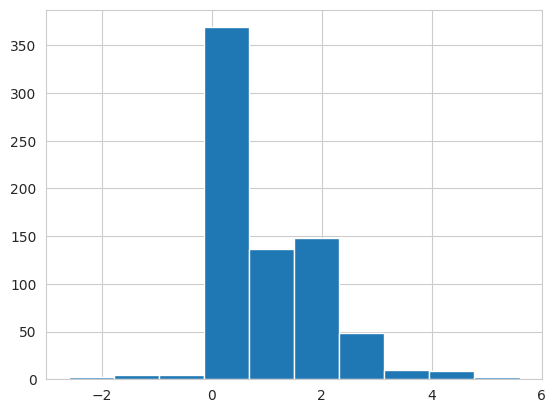

In [34]:
x_train_test['Oldpeak'].hist()

<Axes: >

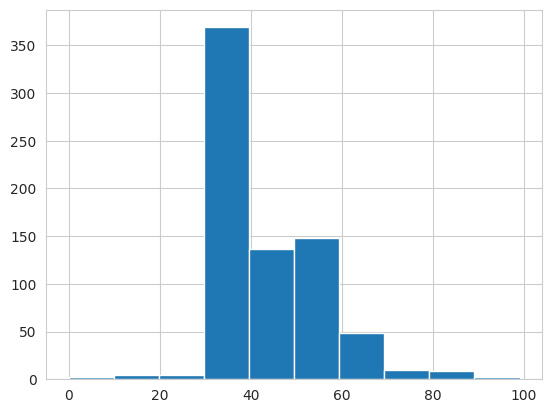

In [35]:
# Coverting continuous variable to
x_train_test_naive_bayes = x_train_test.copy()
no_bins = 100
x_train_test_naive_bayes['Oldpeak'] = pd.cut(x_train_test_naive_bayes['Oldpeak'], bins=no_bins, labels=range(no_bins)).astype(int)
x_train_test_naive_bayes['Oldpeak'].hist()

In [36]:
# Create the MultinomialNB model
model = MultinomialNB()

# Define the parameter distributions (same as the original code, for tuning if needed)
param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10],  # Laplace smoothing
    'fit_prior': [True, False]    # Whether to learn class prior probabilities or use uniform ones
}

# Initialize RandomizedSearchCV with MultinomialNB, parameter distributions, and k-fold cross-validation
grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=kf,
                            verbose=1,
                           scoring='accuracy')

# Fit the model with cross-validation
grid_search.fit(x_train_test_naive_bayes, y_train_test)


# Get best index
idx = grid_search.best_index_

# Store the results
results['multinomial_nb'] = {
    'accuracy_mean': grid_search.best_score_,
    'accuracy_variance': grid_search.cv_results_['std_test_score'][idx]**2,
    'model': grid_search.best_estimator_,
    'params': grid_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"


### SVM

In Support Vector Machines (SVMs), each training example is represented as a point in an N-dimensional feature space. The goal is to classify new data points by finding a hyperplane that separates the categories, placing all points of one class on one side and all points of the other class on the opposite side.

SVM selects the hyperplane that maximizes the margin—the distance between the hyperplane and the closest points from each class. These closest points are called support vectors and are critical in defining the position and orientation of the hyperplane.

When the data is not linearly separable, SVM handles this by:
1.   Mapping the data into a higher-dimensional space using non-linear transformations.
2.   Finding a separating hyperplane in this transformed space.
3.   Projecting the solution back into the original feature space.

The kernel trick enables this process efficiently by computing inner products in the higher-dimensional space without explicitly performing the transformation, saving significant computational resources.


✔️ Pros:
- Works well even when the number of features is greater than the number of samples
- Performs well when there is a clear margin of separation
- memory efficient at prediction time

❌ Cons
- slow to train on large datasets
- choice of hyperparameters is critical
- no direct probability estimates (though methods like Platt scaling can be used post-hoc)
- poor performance on overlapping classes

⚙️ Key Parameters:
- `c` Controls the trade-off between maximizing the margin and minimizing classification error.
  - Typical values: `0.1`, `1`, `10`, `100` (log scale)
  - Lower C: wider margin, more tolerance for misclassification (risk of underfitting).
  - Higher C: narrower margin, less tolerance for misclassification (risk of overfitting).
- `kernel` Defines the type of hyperplane used to separate the data.
  - `linear` – for linearly separable data.
  - `rbf` Radial basis function (Gaussian) kernel (default) – good general-purpose kernel.
  - `poly` – for polynomial decision boundaries. If you use poly you also need a `degree` parameter to express the degree of the polynomial function.
  - `sigmoid` – rarely used.

- `gamma` Defines the influence of a single training example (only for `rbf`, `poly`, and `sigmoid` kernels) .
  - Typical values:
      - `scale` (default, 1 / (n_features * X.var()))
      - `auto` (1 / n_features)
      - or explicit float values like `0.1`, `1`, `10`
  - Low gamma: large similarity radius (smoother decision boundary).
  - High gamma: small radius (tighter boundary, risk of overfitting).

In [37]:
%%time
# Define the pipeline
pipeline = Pipeline([
    ('scaler', _),  # Placeholder for the scaler, filled by param_grid
    ('svm', SVC())
])

# Define the parameter grid for SVM
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Only used for non-linear kernels
}

# Initialize GridSearchCV with cross-validation and accuracy scoring
grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid,
                           cv=kf,
                           scoring='accuracy')

# Fit the model
grid_search.fit(x_train_test, y_train_test)

# Get best index
idx = grid_search.best_index_

# Store the results
results['SVM'] = {
    'accuracy_mean': grid_search.best_score_,
    'accuracy_variance': grid_search.cv_results_['std_test_score'][idx]**2,
    'model': grid_search.best_estimator_.named_steps['svm'],
    'params': grid_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

CPU times: user 35.3 s, sys: 62.1 ms, total: 35.4 s
Wall time: 35.6 s


,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"
SVM,0.863796,0.000344,"SVC(C=1, gamma='auto')","{'scaler': MinMaxScaler(), 'svm__C': 1, 'svm__..."


## Tree Based Methods

### Decision Tree
A Decision Tree is a flowchart-like structure used for classification (and regression). It splits the data based on feature values to create branches, leading to decisions at the leaves.

✔️ Pros:
*   Interpretable and easy to visualize: You can follow the decision path from root to leaf.
*   No need for feature scaling: Works well with raw data, including categorical and numerical features.
*   Captures non-linear relationships: Can model complex decision boundaries.
*   Handles missing values and irrelevant features relatively well.
*   Requires little data preprocessing: No need for one-hot encoding (some implementations support this natively).

❌ Cons:
*   Prone to overfitting, poor generalization: Especially if the tree is deep or not pruned.
*   Unstable: The tree-building process uses greedy, recursive splits (e.g., choosing the best feature to split at each node). If your dataset changes slightly (e.g., one new data point or a slight change in feature values), the best split at a node might change. This change cascades down the tree, resulting in a completely different structure.
*   Biased with imbalanced classes or skewed features: May favor features with more levels.

⚙️ Key Parameters:
*   `max_depth`	Limits how deep the tree can go. Prevents overfitting. Critical for tuning.
*   `min_samples_split`	Controls how many samples are needed to split a node. Higher = less overfitting.
*   `min_samples_leaf`	Ensures leaves have enough data to generalize. Helps smooth predictions.


In [38]:
%%time
# Create model
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)

param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, None], #default = None
    'min_samples_split': [2, 5, 10], # default = 2
    'min_samples_leaf': [1, 2, 4], # default = 1
    'criterion': ['gini', 'entropy'] # default = gini
}


grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           cv=kf,
                           verbose=1,
                           scoring='accuracy')

# Fit the model with cross-validation
grid_search.fit(x_train_test, y_train_test)

# Get best index
idx = grid_search.best_index_

# Store the results
results['decision_tree'] = {
    'accuracy_mean': grid_search.best_score_,
    'accuracy_variance': grid_search.cv_results_['std_test_score'][idx]**2,
    'model': grid_search.best_estimator_,
    'params': grid_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

Fitting 5 folds for each of 126 candidates, totalling 630 fits
CPU times: user 3.84 s, sys: 14.2 ms, total: 3.86 s
Wall time: 3.85 s


,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"
SVM,0.863796,0.000344,"SVC(C=1, gamma='auto')","{'scaler': MinMaxScaler(), 'svm__C': 1, 'svm__..."
decision_tree,0.837890,0.000502,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 3, 'min_..."


#### Plot decision tree

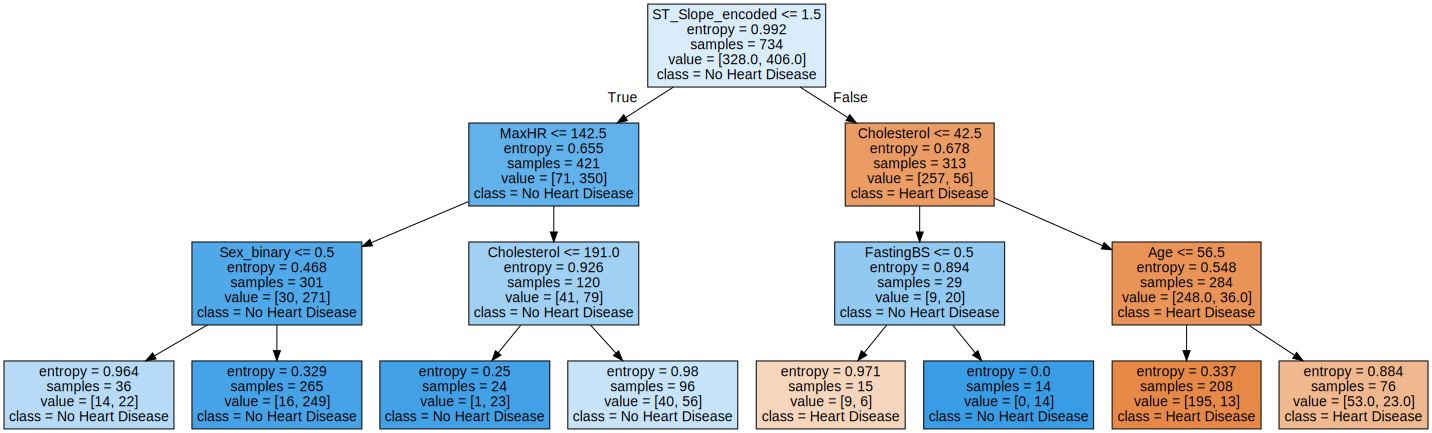

In [39]:
# DOT data
decision_tree_details = tree.export_graphviz(results['decision_tree']['model'],
                                              feature_names=features_df.columns,
                                              class_names=['Heart Disease', 'No Heart Disease'],
                                              filled=True)

# Draw graph
graph = graphviz.Source(decision_tree_details, format="png")
graph

#### Plot Feature Importance

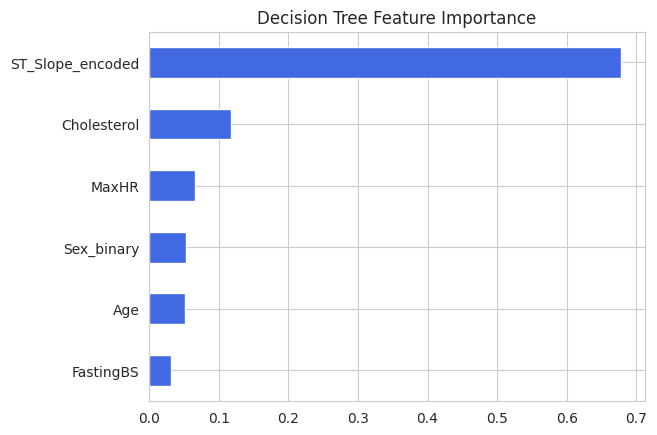

In [40]:
# Get the feature importances from the decision tree model
importances = results['decision_tree']['model'].feature_importances_

# Get the feature names (assuming x_train_test is a DataFrame)
feature_names = x_train_test.columns

# Create a Series to align importance with feature names
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

feature_importance_series[feature_importance_series > 0].plot(kind='barh', color=palette[0],  title='Decision Tree Feature Importance')
plt.show()

In [41]:
print('Features NOT used by model:')
for feat in feature_importance_series[feature_importance_series == 0].index.tolist():
    print(feat)

Features NOT used by model:
RestingBP
Oldpeak
ExerciseAngina_binary
RestingECG_ST
RestingECG_LVH
ChestPainType_TA
ChestPainType_NAP
ChestPainType_ATA


### Random Forest

A Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest returns a class prediction and the class with the most votes becomes our forests. prediction.

Each tree needs to be different to acheive a useful ensemble. To achieve this we randomly sample (with replacement) data from the training dataset to create a new dataset for training each individual decision tree, that is the same size as the original. This is called bootstrapping. Bootstrapping introduces diversity among trees — each tree sees a slightly different subset of data.

At each split within each tree instead of evaluating all features to find the best split, the algorithm randomly selects a subset of features and chooses the best split only from that subset. This adds more variation to the trees.

We introduce variance to reduces the chance that trees all learn the same patterns and overfit the data.

✔️ Pros:
*   High accuracy:	Typically performs very well out of the box.
*   Robust to overfitting:	Aggregating multiple trees reduces variance.
*   Handles non-linear relationships: No need for linear assumptions.
*   Limited Preprocessing:	No need to normalize or standardize features and can handle missing values better than other models. WHY?
*   Feature importance: Provides built-in feature importance estimates.
*   Out-of-bag (OOB) scoring	Enables model validation without a separate test set. WHY

❌ Cons:
*   Not as transparent as a single decision tree.
*   Training many trees takes time and memory.

⚙️ Key Parameters in sklearn.neighbors.KNeighborsClassifier:
*   `n_estimators`	Number of trees in the forest	100–1000+ (more = better performance, but slower)
*   `max_depth`	Max depth of each tree	Controls overfitting; try 5–50, or None (until pure)
*   `min_samples_split`	Min samples required to split a node	2–10+ (larger = simpler trees)
*   `min_samples_leaf`	Min samples at a leaf node	1–10+ (larger = smoother model)
*   `max_features`	# features to consider at each split	'sqrt' (default), 'log2', float (e.g., 0.5)
*   `bootstrap`	Whether to use bootstrapping	Usually True (set False for extra randomness)
*   `class_weight`	Adjusts for class imbalance	'balanced', 'balanced_subsample', or custom dict
*   `random_state`	For reproducibility
*   `oob_score`	Use out-of-bag samples for validation	True or False

#### RandomSearchCV
`RandomSearchCV` randomly samples from the defined hyperparameter distributions, allowing it to explore a wide range of possibilities more quickly than `GridSearchCV`, though it may not always find the absolute best combination.

`GridSearchCV` uses `param_grid` to define a fixed grid of parameters, whereas `RandomizedSearchCV` uses `param_distributions` to specify distributions from which values should be sampled.

`n_iter`: Specifies how many random parameter combinations to try.

In [42]:
%%time
# Create model
model = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    # None: The number of features to consider is set to the total number of features in the dataset.
    # sqrt: The number of features to consider for each split is set to the square root of the total number of features.
    'max_features': [None, 'sqrt']
}


random_search = RandomizedSearchCV(estimator=model,
                           param_distributions = param_distributions,
                           n_iter=100,
                           cv=kf,
                           verbose=1,
                           scoring='accuracy')

# Fit the model with cross-validation
random_search.fit(x_train_test, y_train_test)

# Get best index
idx = random_search.best_index_

# Store the results
results['random_forest'] = {
    'accuracy_mean': random_search.best_score_,
    'accuracy_variance': random_search.cv_results_['std_test_score'][idx]**2,
    'model': random_search.best_estimator_,
    'params': random_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 4min 13s, sys: 976 ms, total: 4min 14s
Wall time: 4min 18s


,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"
SVM,0.863796,0.000344,"SVC(C=1, gamma='auto')","{'scaler': MinMaxScaler(), 'svm__C': 1, 'svm__..."
decision_tree,0.837890,0.000502,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 3, 'min_..."
random_forest,0.867850,0.000306,"(DecisionTreeClassifier(max_features='sqrt', m...","{'n_estimators': 100, 'min_samples_split': 10,..."


#### Plot Feature Importance

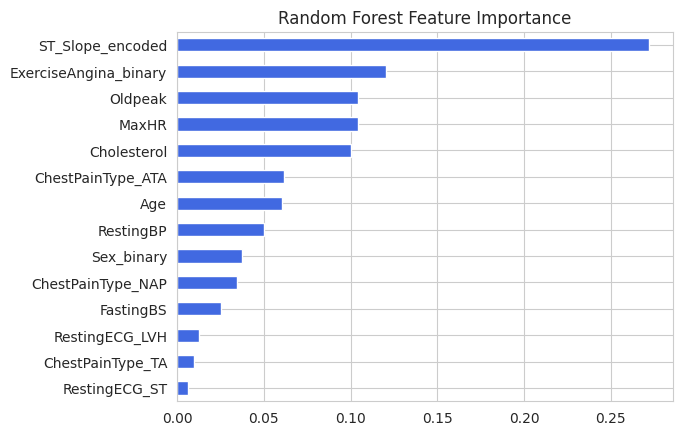

In [43]:
# Get the feature importances from the decision tree model
importances = results['random_forest']['model'].feature_importances_

# Get the feature names (assuming x_train_test is a DataFrame)
feature_names = x_train_test.columns

# Create a Series to align importance with feature names
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

feature_importance_series[feature_importance_series > 0].plot(kind='barh', color=palette[0], title='Random Forest Feature Importance')
plt.show()

### XGBoost

Unlike random forests, which build many trees in parallel, XGBoost builds trees sequentially, each one correcting the errors of the previous.

While random forests average many deep trees trained on bootstrapped samples (bagging), XGBoost builds trees one at a time, where each tree learns to fix the residual errors of the current model (boosting).

You start with a very simple model. Then each subsequent model adds a (relatively simple) layer of complexity. Each new tree is trained to fit the residuals (errors) of the current model across all training examples, not just a single one.

---

**Example:**

If we are predicting house price using this data:

| House | Size (sqft) | Bedrooms | Age | True Price (£) |
|-------|-------------|----------|-----|----------------|
| A     | 1000        | 2        | 10  | 300,000        |
| B     | 1500        | 3        | 5   | 450,000        |
| C     | 800         | 2        | 20  | 220,000        |


Layer 1: A naive model might predict the mean of house prices.

| House | True Price (£) | Initial Prediction (£) | Residual (Error) |
|-------|----------------|-------------------------|------------------|
| A     | 300,000        | 323,333                 | -23,333          |
| B     | 450,000        | 323,333                 | +126,667         |
| C     | 220,000        | 323,333                 | -103,333         |

Layer 2: A decision tree is then trained to predict the residuals using the features. It's outputs will be something like this:

| House | Tree Output (Correction) |
|-------|--------------------------|
| A     | -20,000                  |
| B     | +120,000                 |
| C     | -90,000                  |

We add the tree’s output to our model’s predictions, scaled by a learning rate (e.g. η = 0.1).

`Updated Prediction = Previous + (Learning Rate × Tree Output)`

| House | Updated Prediction (£)                      |
|-------|---------------------------------------------|
| A     | 323,333 + 0.1 × (-20,000) = 321,333         |
| B     | 323,333 + 0.1 × (120,000) = 335,333         |
| C     | 323,333 + 0.1 × (-90,000) = 314,333         |

This repeats until we reach the predetermined number of estimators (trees).

---

✔️ Pros:
*   Very fast and efficient due to optimized implementation (parallelized and supports GPU).
*   Typically achieves high accuracy on structured/tabular data.
*   Built-in regularisation (`alpha`, `lambda`) helps prevent overfitting.
*   Handles missing values internally.
*   Supports early stopping and incremental training.

❌ Cons:
*   Can overfit if not properly tuned, especially with small datasets.
*   Requires careful hyperparameter tuning for best performance.
*   More complex than simpler models — harder to interpret without tools (e.g., SHAP).
*   External dependency (`xgboost` library must be installed separately).

⚙️ Key Parameters:
*   `n_estimators`: Number of trees in the ensemble.
*   `learning_rate`: Step size shrinkage to prevent overfitting.
*   `max_depth`: Maximum tree depth (controls model complexity).
*   `subsample`: Fraction of training data used for each tree (helps regularization).
*   `colsample_bytree`: Fraction of features used per tree (helps regularization).
*   `gamma`: Minimum loss reduction required for a split (used for pruning).
*   `reg_alpha`: L1 regularization term on weights.
*   `reg_lambda`: L2 regularization term on weights.

In [44]:
%%time
# Create model
model = XGBClassifier(random_state=42)

# Define the parameter distributions for XGBoost
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 2, 3, 5, 7, 10],  # XGBoost typically uses smaller max_depth values
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate to control the step size
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],  # Regularization parameter to control overfitting
    'min_child_weight': [1, 2, 5],  # Minimum sum of instance weight (hessian) in a child
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   n_iter=300,
                                   cv=kf,
                                   verbose=1,
                                   scoring='accuracy')

# Fit the model with cross-validation
random_search.fit(x_train_test, y_train_test)

# Get best index
idx = random_search.best_index_

print(random_search.best_params_)

# Store the results
results['xgboost'] = {
    'accuracy_mean': random_search.best_score_,
    'accuracy_variance': random_search.cv_results_['std_test_score'][idx]**2,
    'model': random_search.best_estimator_,
    'params': random_search.best_params_,
}

pd.DataFrame.from_dict(results, orient='index')

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'subsample': 0.9, 'n_estimators': 50, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
CPU times: user 4min 5s, sys: 4.81 s, total: 4min 9s
Wall time: 2min 30s


,accuracy_mean,accuracy_variance,model,params
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"
SVM,0.863796,0.000344,"SVC(C=1, gamma='auto')","{'scaler': MinMaxScaler(), 'svm__C': 1, 'svm__..."
decision_tree,0.837890,0.000502,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 3, 'min_..."
random_forest,0.867850,0.000306,"(DecisionTreeClassifier(max_features='sqrt', m...","{'n_estimators': 100, 'min_samples_split': 10,..."
xgboost,0.870599,0.000235,"XGBClassifier(base_score=None, booster=None, c...","{'subsample': 0.9, 'n_estimators': 50, 'min_ch..."


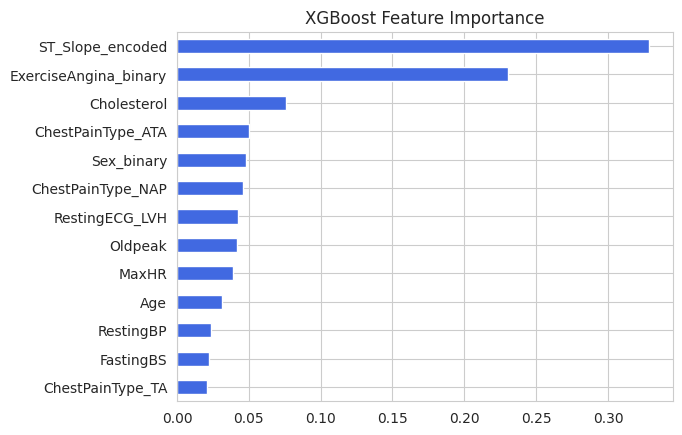

In [45]:
# Get the feature importances from the decision tree model
importances = results['xgboost']['model'].feature_importances_

# Get the feature names (assuming x_train_test is a DataFrame)
feature_names = x_train_test.columns

# Create a Series to align importance with feature names
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

feature_importance_series[feature_importance_series > 0].plot(kind='barh', color=palette[0], title='XGBoost Feature Importance')
plt.show()

# Model Selection

**accuracy_mean**: The average accuracy score achieved by the model across all cross-validation folds for the best found hyperparameters. This gives a reliable estimate of how well the model performs on unseen data.

**accuracy_variance**: The variance (square of the standard deviation) of the accuracy scores across the cross-validation folds for the best hyperparameters. This measures how consistent the model’s performance is; a lower variance indicates more stable results.

In [46]:
final_results = pd.DataFrame.from_dict(results, orient='index').sort_values('accuracy_mean', ascending=False)
final_results

,accuracy_mean,accuracy_variance,model,params
xgboost,0.870599,0.000235,"XGBClassifier(base_score=None, booster=None, c...","{'subsample': 0.9, 'n_estimators': 50, 'min_ch..."
random_forest,0.867850,0.000306,"(DecisionTreeClassifier(max_features='sqrt', m...","{'n_estimators': 100, 'min_samples_split': 10,..."
SVM,0.863796,0.000344,"SVC(C=1, gamma='auto')","{'scaler': MinMaxScaler(), 'svm__C': 1, 'svm__..."
logistic_regression,0.854254,0.000318,"LogisticRegression(C=0.1, l1_ratio=0.9, max_it...","{'logreg__C': 0.1, 'logreg__l1_ratio': 0.9, 'l..."
KNN,0.854235,0.000230,"KNeighborsClassifier(n_neighbors=23, weights='...","{'knn__n_neighbors': 23, 'knn__weights': 'dist..."
decision_tree,0.837890,0.000502,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 3, 'min_..."
multinomial_nb,0.689349,0.000323,"MultinomialNB(alpha=0, fit_prior=False)","{'alpha': 0, 'fit_prior': False}"


*   As expected, the ensemble models achieve the highest accuracy.

*   XGBoost stands out with the highest mean accuracy of 0.872 and a very low variance (0.000296), showing consistent performance across different data splits, making it the preferred model for this task.

*   If interpretability is a priority (e.g., explaining predictions to clinicians), logistic regression is a strong alternative since its accuracy is only slightly lower than the top models.

# Final Evaluation
Evaluating the model's performance on the holdout set to assess its final accuracy.

In [47]:
final_model = results['xgboost']['model']

y_pred = final_model.predict(x_validate)

# Evaluate accuracy (or another metric)
test_accuracy = final_model.score(x_validate, y_validate)
test_accuracy

0.8858695652173914

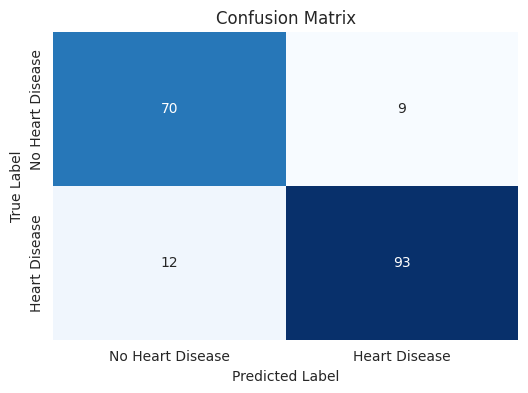

In [48]:
cm = confusion_matrix(y_pred, y_validate)

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model correctly classified 72 patients without heart disease and 94 patients with heart disease. It misclassified 8 patients without heart disease as having the disease (false positives) and 10 patients with heart disease as healthy (false negatives). Overall, the model shows good performance with relatively balanced errors, slightly favoring correct detection of heart disease cases.

In cross-validation, the model achieved an average accuracy of 87%, while in this final evaluation, accuracy improved to 90%. This increase suggests the model generalizes well to unseen data and that the final test set may have been slightly easier to classify. However, the close accuracy values indicate the model is stable and reliable, reducing concerns about overfitting.

Focusing on reducing false negatives further would be important to minimize missed heart disease diagnoses.

#### Shap Interpretation

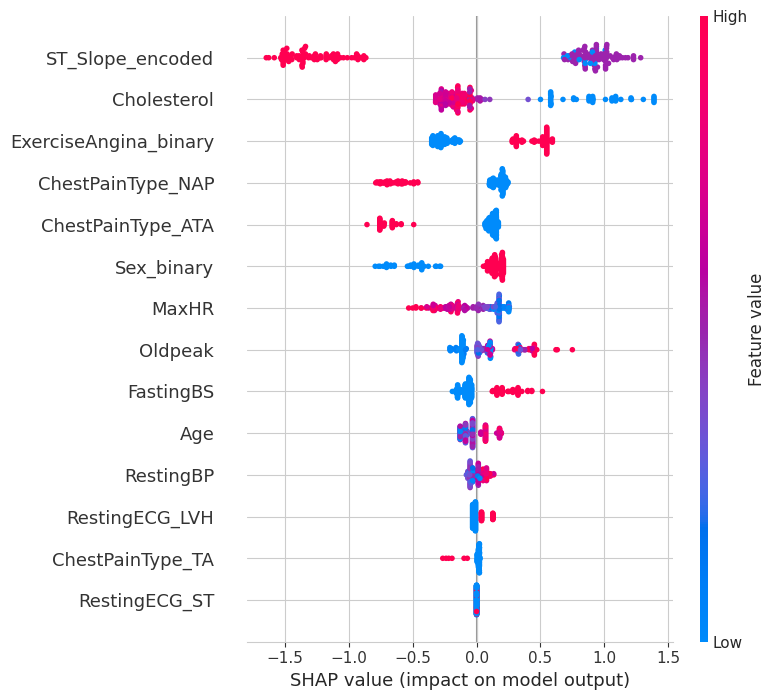

In [49]:
# Create a TreeExplainer for your model
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for your dataset (e.g., validation set or test set)
shap_values = explainer.shap_values(x_validate)

shap.summary_plot(shap_values, x_validate)

Positive SHAP value → pushes prediction toward heart disease.

Negative SHAP value → pushes prediction toward no heart disease.

The further from zero, the stronger the effect.


**Features that push the model to making a heart disease prediction:**
*   Low chloesteral*
*   Not having ChestPainType = NAP (Non-Anginal Pain)
*   Not having ChestPainType = Typical Angina pain (ATA)
*   Sex_binary = 1 (Male)


**Features that push the model to making a NOT heart disease prediction:**
*   High ST-Slope encoded -> upsloping
*   ChestPainType = NAP (Non-Anginal Pain)
*   ChestPainType = Typical Angina pain (ATA)
*   Sex_binary = 0 (Female)

*The cholesteral feature is suprising to me and goes against my intial expectations. However, this relationship can be seen in the initial data exploration boxplot.